## Intuiciones respecto a la relacion entre bias / variance / underfitting y overfitting

**Queremos ver la relacion entre sesgo y varianza y underfitting y overfitting. Alto sesgo esta relacionado con underfitting.** 

Generemos esto con un dataset sintético con una relacion cuadratica entre `x` e `y`

queremos predecir algo donde hay una unica feature que es "x" y el unico target es "y". La relacion es cuadratica.

In [1]:
import numpy as np

def sample_data(size=100, x_matrix=False, min_x=-2.5, max_x=2.5):
    x = (np.random.random(size=size) - 0.5 ) * (max_x - min_x)
    x.sort() # util para graficar
    y = x ** 2 + x + np.random.normal(0, 1, size=size) # le sumo ruido
    if x_matrix:
        x = x.reshape((-1,1))
    return x, y
  # S sim D^m es decir S = sample_data(m) , ver mas abajo foto

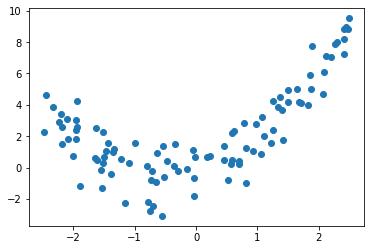

In [2]:
import matplotlib.pyplot as plt
# cambia con cada corrifa
X, y = sample_data(size=100, x_matrix=True)
plt.scatter(X, y) # tengo que chequear que el ruido no desdibuje la forma

In [3]:
X.shape # es asi para que funciones con sklearn

(100, 1)

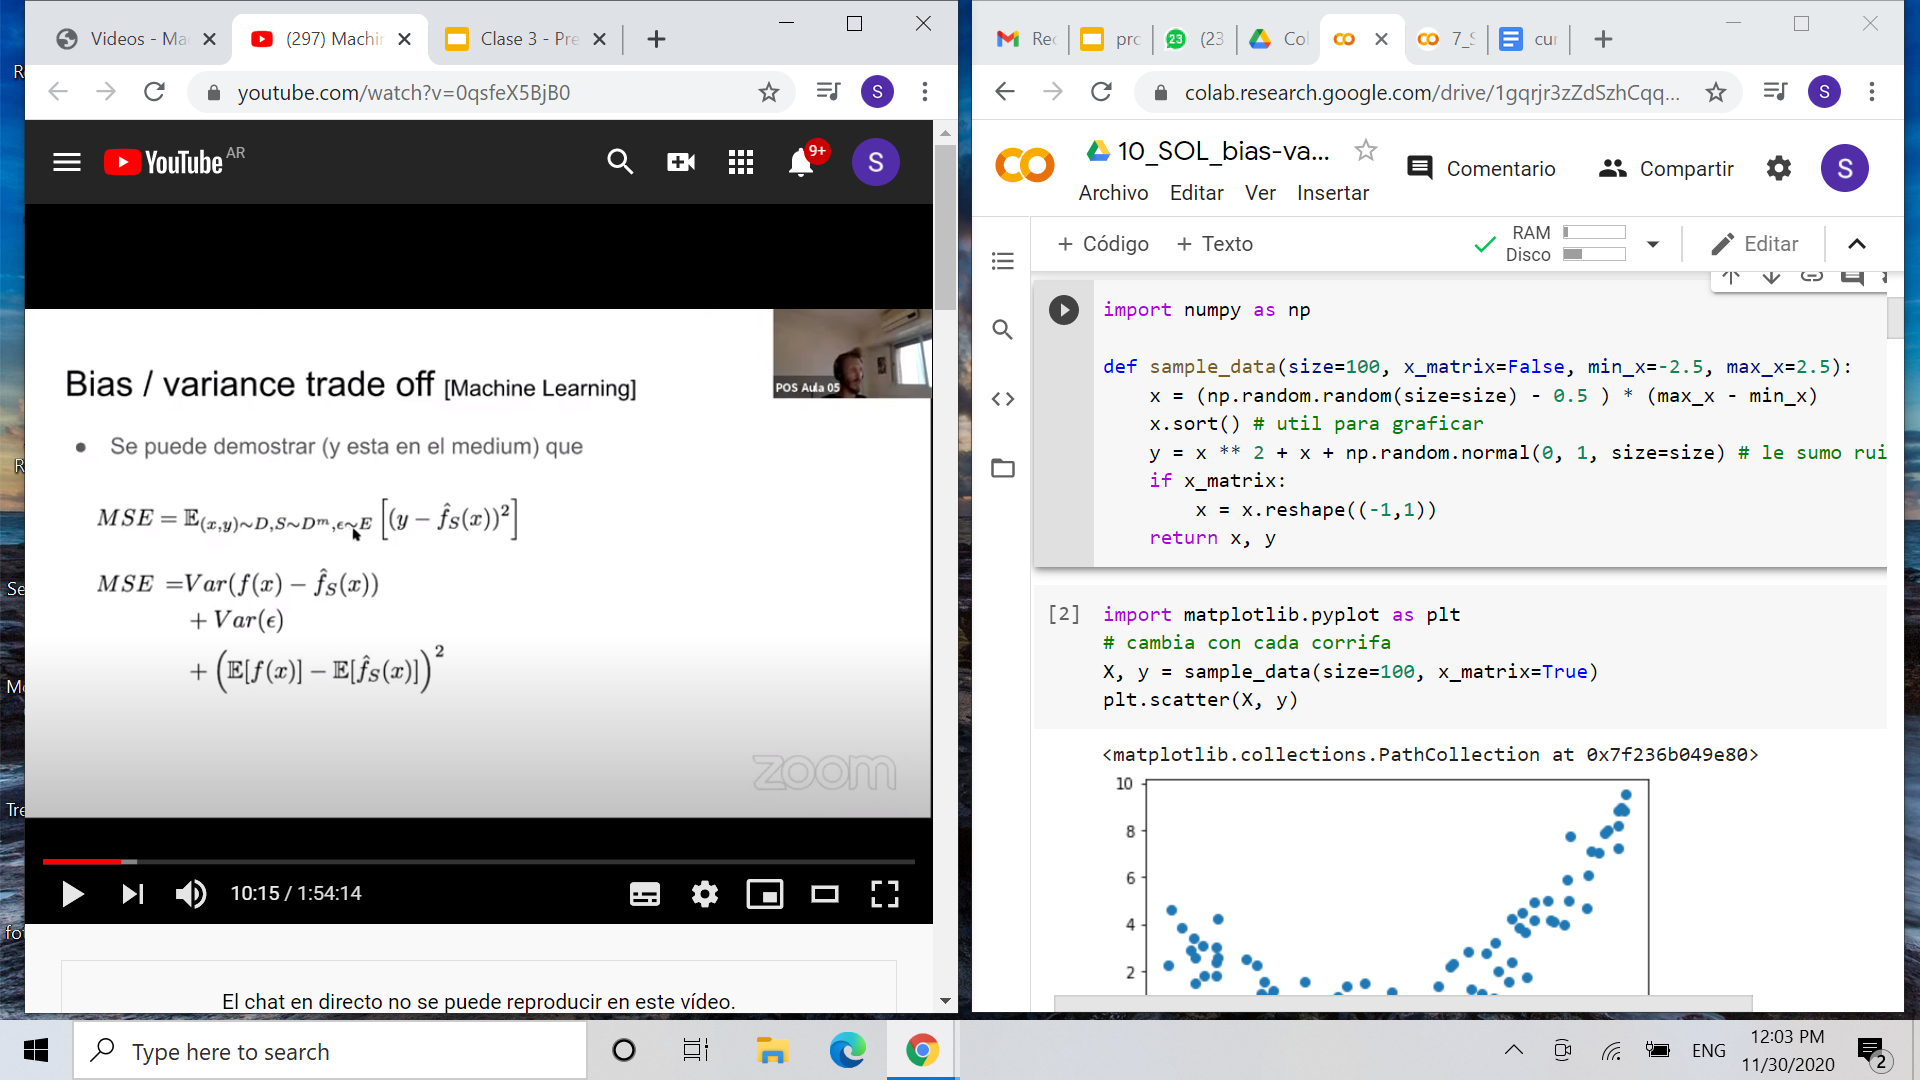

Elijo un datapoint de mi distribucion ((x,y) sim D), elijo un dataset de entrenamiento de tamanio m (S sim D^m), elijo un error (e sim E, es sumarle un ruido con distribucion normal, esta metido en f). Con estas cosas elegidas al azar tomo la esperanza.  Muchas veces elijo un datapoint al azar, elegir un datatrain al azar, elegir un error al azar y hacer esto muchas veces y tomar un promedio de lo que queramos. Es una forma a la montecarlo de estimar cosas (en este caso de estimar el MSE). Eso es lo que vamos a hacer es este notebook.

Ademas eso se puede descomponer en:
* error de medicion (el error de la regla, el var(e)), 
* la varianza del error (var(f-f_S), mide si yo le doy dos datasets distintos al modelo para aprender cuanto va a cambiar la distribucion del error sobre data que no vio, el x sim D esta sampleado de forma independiente del dataset de train, es un error de generalizacion, que se mide sobre cosas que no vi al entrenar) y 
* la esperanza de la funcion posta f(x) menos la esperanza de mi estimador (si yo tomo varios datos de entrenamiento y voy entrenando, cual seria el promedio , el valor esperado).

# Underfitting

Vamos a ajustar esta función cuadratica con una regresion lineal

**Underfitting corresponde a cuando entrenamos un modelo que no tiene la capacidad de ajustarse a los datos que tenemos.**

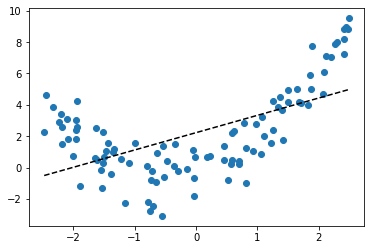

In [4]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(X, y) # entreno el modelo lineal

m, M = X.min(), X.max()

plt.plot([m, M], lr.predict([[m], [M]]), '--k')
plt.scatter(X, y)

Tiene una tendencia positiva, pero el modelo no representa para nada los datos. 

Este es un caso típico de underfitting, la capacidad del modelo no es suficiente para explicar los datos

### Como se comporta con una parte de la distribución que nunca vio?

Vamos a evaluar la regresion lineal en un intervalo de datos que nunca vio, que involucran al `[-5, 5]` en lugar de `[-2.5, 2.5]` con lo que fue entrenado

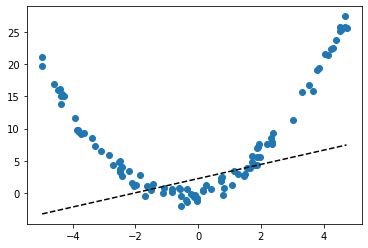

In [5]:
oos_X, oos_y = sample_data(min_x=-5, max_x=5, x_matrix=True)

m, M = oos_X.min(), oos_X.max()
plt.plot([m, M], lr.predict([[m], [M]]), '--k')

plt.scatter(oos_X, oos_y)

La prediccion esta determinada por el sesgo que introdujimos nosotros. Este sesgo viene al determinar que el espacio de modelos que vamos a explorar, corresponde solo al de las funciones lineales en x

# Fiteamos muchos modelos lineales

Veamos como varian las predicciones si entrenamos muchos modelos lineales.

Podemos ver que el error es sistemáticamente alto

In [6]:
def sample_predictions(model, x, iters=100): # samplea predicciones
    """
    Toma `iters` muestras de datos, entrena un modelo con esos datos 
    Devuelve las predicciones de los modelos
    """
    ys_hat = []
    for _ in range(iters):
        X_train, y_train = sample_data(100, x_matrix=True) #dataset de 100 elementos
        model.fit(X_train, y_train)
        ys_hat.append(model.predict(x))
    return np.asarray(ys_hat)

In [7]:
def expected_prediction(model, x, iters=100):
  return sample_predictions(model, x, iters=iters).mean(axis=0)

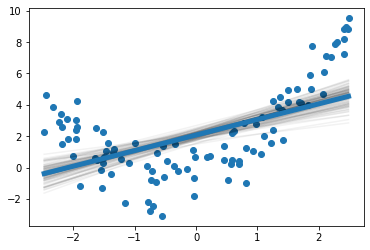

In [9]:
ys = sample_predictions(LinearRegression(), X) # tome una muestra de datos separada, entrene el modelo y predigo, eso lo hago muchas veces. Se ve que depende el fitteo del sampleo
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y) # corresponden a los mismos puntos del dataset con los que entrenamos antes
plt.plot(X,expected_prediction(LinearRegression(), X), lw=5) # la esperanza del modelo lineal, tiene que ver mucho con E(f_S) en el tercer termino de la ecuacion de la imagen que esta pegada

Podemos ver que si bien con distintos samples de los datos se obtienen diferentes modelos, son todos bastante parecidos entre si, y hacen predicciones similares (baja varianza). La varianza es sobre el error !! Ver primer termino del segundo renglon en la imagen pegada. Es el error entre la funcion real f(x) y la funcion estimada f_S. Lo importante no es tanto que los modelos no cambien entre si, sino  como cambia la distribucion del error. Si tengo un modelo que es return = 42, es el modelo con varianza mas baja del mundo, porque los errores van a hacer siempre iguales. siempre devuelve lo mismo. Hay una relacion entre cuanto cambia el modelo entre 2 datasets y la varianza de los errores. 

# Cambiando regresion lineal por arbol de decisión

In [10]:
from sklearn.tree import DecisionTreeRegressor
from ipywidgets import interact, widgets

def draw(min_samples_leaf):
    dt = DecisionTreeRegressor(min_samples_leaf=min_samples_leaf).fit(X, y)

    plt.plot(X, dt.predict(X), '--k')
    plt.scatter(X, y)
    
interact(
    draw, 
    min_samples_leaf=widgets.IntSlider(min=1, max=50, step=1, value=1)
);

interactive(children=(IntSlider(value=1, description='min_samples_leaf', max=50, min=1), Output()), _dom_class…

si la cantidad de datos para 1 hoja=1 (min sample leaf), el arbol memoriza el dataset (overfitting). Si le subo el min sample leaf hay menos cortes en el arbol, pues necesita minimo 11 bolitas para hacer un corte. Si lo subo al maximo estoy haciendo underfitting. 

#### Que pasa si lo miramos con observaciones fuera del rango entrenado?

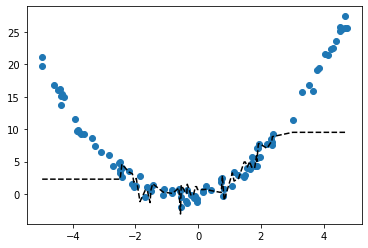

In [11]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(min_samples_leaf=1).fit(X, y)
plt.plot(oos_X, dt.predict(oos_X), '--k')
plt.scatter(oos_X, oos_y)

fuera del rango que no vio en el training set no sabe que hacer. 

Podemos ver como se ajusta a la perfeccion a los datos

# Haciendo muchas predicciones

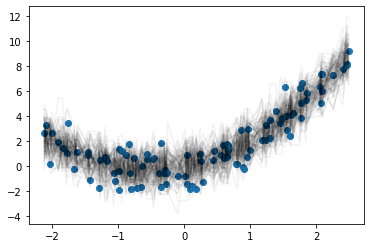

In [ ]:
ys = sample_predictions(DecisionTreeRegressor(), X) # 100 modelos de arbol con un sample de los datos
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y) # son el training set de siempre que sampleamos al principio

**al overfittear esta memorizando la senial (x^2+x) y el ruido (la normal): la sombra oscura es donde estan los datos. Si hay mas senial que ruido y hago underfitting, el modelo solo va a tomar la caracteristica mas general (pendiente positiva) y no va a poder decir nada mas.**

Podemos ver que al tomar muchas muestras los modelos terminan cubriendo la zona de alta densidad de bolitas

Podemos ver que el modelo esperado se parece mucho a la funcion que genera los datos

In [ ]:
def expected_prediction(model, x, iters=100):
    return sample_predictions(model, x, iters=iters).mean(axis=0)

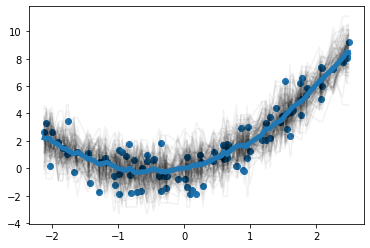

In [ ]:
ys = sample_predictions(DecisionTreeRegressor(), X)
plt.plot(X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)
plt.plot(X, expected_prediction(DecisionTreeRegressor(), X), lw=5)

Podemos ver que en esperanza el modelo le pega muy bien, sin embargo en cada realizacion del dataset

### Como se ve con observaciones out of sample?

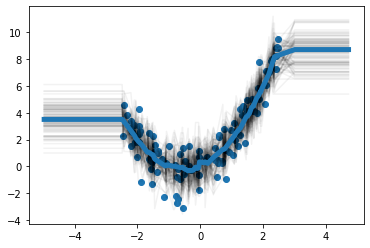

In [13]:
ys = sample_predictions(DecisionTreeRegressor(), oos_X)
plt.plot(oos_X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)
plt.plot(oos_X, expected_prediction(DecisionTreeRegressor(), oos_X,iters=100), lw=5)
# se aumento iters la cuadratica da mas linda 

fuera de los datos que vio, le erra tmb. Es un sesgo del arbol: la forma en la que el arbol construye las estimaciones es asi: corto y tomo promedios. Es un sesgo que esta codificado por elegir un arbol. En los datos que si conoce le pega muy bien.

# Calculando sesgo y varianza

![image.png](attachment:image.png)

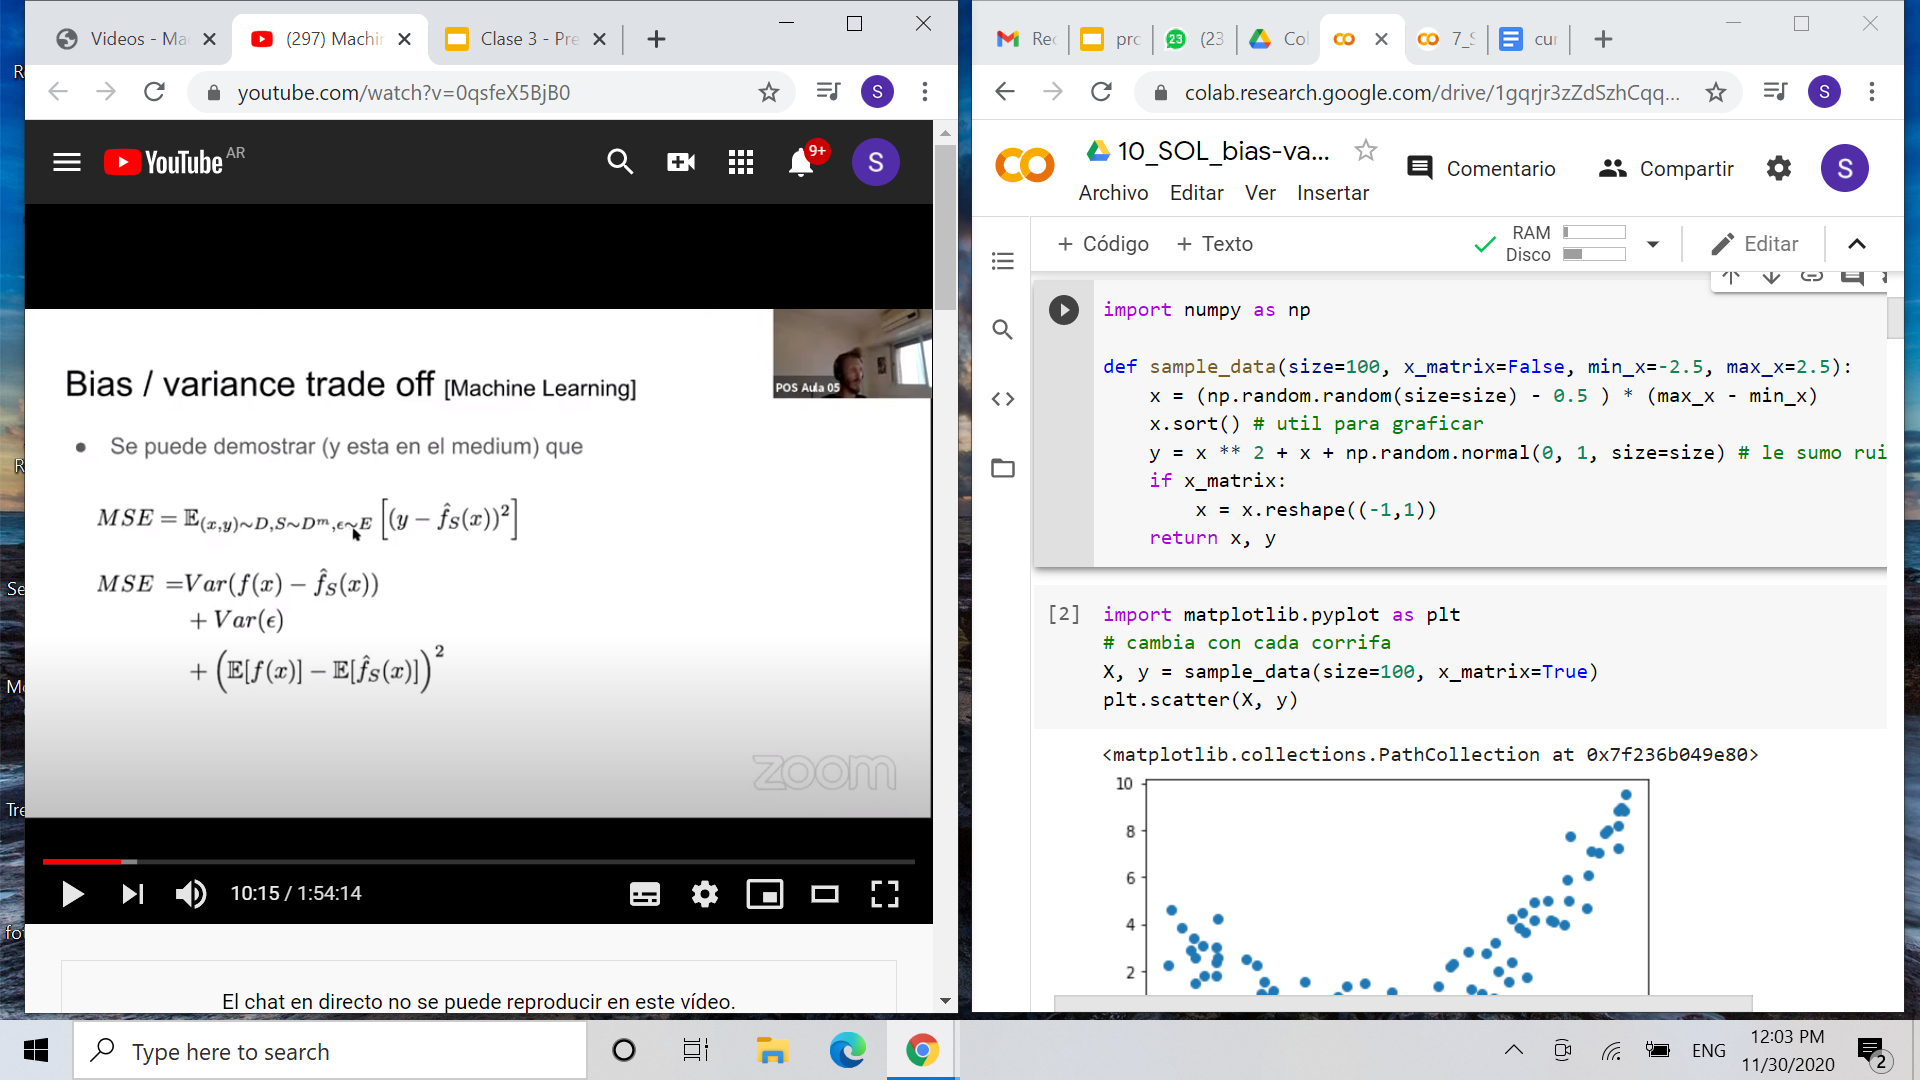

**Para poder hacer estimaciones sobre el mse como el primer renglon, tengo que hacer repetidas veces elegir un data set (D^m), entrenar un modelo y evaluar el error.** 
**Si lo hago como el segundo renglon, estimando solo el var(f-f_s) y el (E(f)-E(f_S))^2, es lo mismo: el termino (E(f)-E(f_S))^2 me obliga a entrenar con muchos modelos y ver la esperanza. En rigor eso es para un unico data point, pero Pablo lo hizo para muchos datapoints y promedio.** 

Recordar que en las esperanzas de la segunda ecuacion son sobre las variables que estan en la expresion de MSE.

En este caso, por construccion **sabemos** el valor de `E[f(x)]`.
Es decir `E[f(x)] = x^2 + x` (ver funcion sample_data)

Con eso podemos calcular el sesgo y la varianza para este caso

Vamos a calcular la varianza (f-f_s) y el sesgo (E_f-E_f_s)^2.
* el sesgo (E_f-E_f_s)^2 : necesito calcular E_f, la esperanza de f(x) para un datapoint y despues para muchos, para despues tomar un promedio. f(x)=x^2+x. Luego necesito la esperanza de mi modelo en x (E_f_s). 
* la varianza: calculo muchas veces var (f-f_s) y tomo un promedio. Tengo un datapoint y tengo la varianza del error entre f(x) y f_s(x). Tengo que elegir muchos datasets S, entrenar al modelo con cada uno de esos datasets, calcular ese error para ese datapoint y tomar la varianza del error. Eso me da un valor de var(f-f_S). Repito lo anterior varias veces y calculo un promedio de var(f-f_S).  

In [14]:
def bias(model, x, y, iters=100):
    ideal_y = (x**2 + x).squeeze() #E_f, en la vida real no se el ideal_y
    errors = (
        ideal_y - expected_prediction(model, x, iters=iters) #(E_f-E_f_s)**2
    ) ** 2
    return errors.mean()
#expected_prediction agarra el modelo , agarra el x, samplea muchas veces un training set, entrena el modelo con ese training set , predice sobre x y luego toma un promedio de (E_f-E_f_s)**2
def variance(model, x, y, iters=100):
    ideal_y = (x**2 + x).squeeze()
    # repetimos la esperanza en `iters` filas para facilitar el computo
    ideal_y = np.repeat(ideal_y.reshape((1, -1)), iters, axis=0)
    
    # sampleamos iters predicciones de modelos
    ys_hat = sample_predictions(model, x, iters=iters) # 1000 predicciones para varios datasets distintos 
    
    # Estimamos la varianza por cada par (x_i, y_i) del dataset, luego promediamos las varianzas
    return np.var(ideal_y - ys_hat, axis=0).mean()

De esta forma podemos calcular el sesgo y la varianza de una regresion lineal

In [16]:
bias(LinearRegression(), *sample_data(1000, x_matrix=True), iters=100)

3.4390629114632536

In [17]:
variance(LinearRegression(), *sample_data(1000, x_matrix=True), iters=1000)

0.10947851406410189

Tiene varianza baja. El modelo lineal tiene mucho sesgo porque pifia de manera consisitente para nuestro problema cuadratico. El bias/sesgo (E_f-E_f_s)**2 es alta. La varianza es baja porque los modelos son todos parecidos para distintos dataset de training, ergo los errores no cambian mucho. 

**Si tenemos sesgo alto es que estamos underfitting, le tenemos que agregar capacidad de expresion al modelo. Regularizacion hace justamente lo contrario. Deberia aumentar el sesgo y bajar la varianza si agrego regularizacion.** 

### Que pasa si jugamos con regularizacion L2?

A la regresion con regularizacion L2 se le suele llamar `Ridge`. El parámetro lambda en scikit-learn se llama alpha (a mas grande, mayor regularizacion)

In [18]:
from sklearn.linear_model import Ridge

bias(Ridge(alpha=500), *sample_data(1000, x_matrix=True), iters=1000)

4.475067829873606

In [19]:
variance(Ridge(alpha=500), *sample_data(1000, x_matrix=True), iters=1000)

0.06124196260120516

Efectivamente me da mayor sesgo y menor varianza.

### Y podemos calcular el sesgo y la varianza de un decision tree

In [20]:
bias(
    DecisionTreeRegressor(min_samples_leaf=1), 
    *sample_data(1000, x_matrix=True), 
    iters=1000
)

0.0014715125981746117

In [21]:
variance(
    DecisionTreeRegressor(min_samples_leaf=1), 
    *sample_data(1000, x_matrix=True), 
    iters=1000
)

1.0042902484851968

Cuando pongo min sample leaf =1 (overfitting) el sesgo/bias es bajisimo.  El sesgo compara (E_f-E_f_s)**2 y E_f y E_f_s son muy parecidas en el dominio de training set. 

Ahora la varianza es grande. 

Se puede ver que el decision tree tiene **muchisimo menos sesgo**, pero tiene una varianza 10 veces mas alta.

### Qué pasa si utilizamos min_samples_leaf = 10?

cambiar el min sample leaf es como regularizar. 

In [22]:
bias(
    DecisionTreeRegressor(min_samples_leaf=10), 
    *sample_data(1000, x_matrix=True), 
    iters=1000
)

0.09931808614872571

In [ ]:
variance(
    DecisionTreeRegressor(min_samples_leaf=10), 
    *sample_data(1000, x_matrix=True), 
    iters=1000
)

0.4022126724472044

In [23]:
plt.boxplot(
    [
        variance(
            DecisionTreeRegressor(min_samples_leaf=10), 
            *sample_data(1000, x_matrix=True), 
            iters=100
        )
        for i in range(100)
    ],
        [
        variance(
            DecisionTreeRegressor(min_samples_leaf=15), 
            *sample_data(1000, x_matrix=True), 
            iters=100
        )
        for i in range(100)
    ]
)

KeyboardInterrupt: ignored

In [24]:
from ipywidgets import interact, widgets

def draw_predictions(min_samples_leaf):
    ys = sample_predictions(
        DecisionTreeRegressor(min_samples_leaf=min_samples_leaf), 
        oos_X,
        iters=100
    )
    plt.plot(oos_X, ys.T, color='k', alpha=0.05);
    plt.scatter(X, y)
    plt.plot(
        oos_X, 
        expected_prediction(
            DecisionTreeRegressor(min_samples_leaf=min_samples_leaf), 
            oos_X
        ), 
        lw=5
    )
    plt.xlim(-5, 5)
    plt.ylim(-4, 12)
    

interact(
    draw_predictions, 
    min_samples_leaf=widgets.IntSlider(min=1, max=50, step=1, value=10)
);

interactive(children=(IntSlider(value=10, description='min_samples_leaf', max=50, min=1), Output()), _dom_clas…

con el min sample leaf alto, le aumento el sesgo (underfitting).  

# Un modelo con el sesgo perfecto

**El sesgo lo controlamos nosotros. Podemos introducir un sesgo que sea util para nuestra problematica.** 

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Ajustamos un modelo cuadrático, eso es con sesgo perfecto
model = make_pipeline(PolynomialFeatures(), LinearRegression())

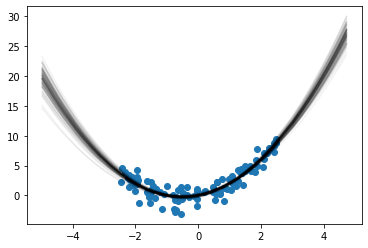

In [26]:
ys = sample_predictions(model, oos_X)
plt.plot(oos_X, ys.T, color='k', alpha=0.05);
plt.scatter(X, y)

En este caso, al elegir el sesgo correcto (modelo cuadratico para datos cuadraticos), el modelo generaliza inclusive a datos nunca vistos de forma correcta.


En este caso tenemos un modelo de bajo sesgo y baja varianza (algo muy raro en la práctica). 

Si bien este es un ejemplo de juguete, sirve para ejemplificar como un sesgo introducido de forma correcta al problema puede ser muy beneficioso en la calidad del modelo final

In [27]:
bias(
    model,
    *sample_data(1000, x_matrix=True), 
    iters=1000
)

7.95383106090944e-05

In [28]:
variance(
    model,
    *sample_data(1000, x_matrix=True), 
    iters=1000
)

0.030927489728023488

El sesgo y la varianza en este caso dan ordenes de magnitud mas bajos que en los casos anteriores. 

Es importante sentarse a pensar cual es el problema que queremos resolver. Si pensamos bien eso, elegimos perfecto el modelo (sesgo perfecto) y ahi no da mal por fuera del rango estudiado.

Mucha varianza es overfitting. 

**ensambles de arboles (random forest, etc) hacen lo que se llama sampling with replacement de arbol en arbol  (datasets nuevos con la misma distribucion estadistica del dataset original).**